# Wannierisation (including SAWF)

This tutorial shows how to construct (Symmetry adapted) Wannier functions with WannierBerri, with magnetic symmetries. We will use the example of bcc Fe.

## 0. Compute QuantumEspresso files

in tthe tutorial repository only the input files for Quantum ESPRESSO are provided
to obtain the necessary files one needs to run
```
pw.x < Fe_pw_scf_in > Fe_pw_scf_out
pw.x < Fe_pw_nscf_in > Fe_pw_nscf_out
wannier90.x -pp Fe
pw2wannier90.x < Fe_pw2wan_in > Fe_pw2wan_out
```
 
## 1. Setup

First import modules and set up the parallel environment



In [1]:
import ray
# Initialize Ray with 8 CPU cores
# Do this only once at the beginning of your script. Initializing multiple times will lead to errors.
ray.init(num_cpus=8)
# If needed, you can do ray.shutdown() at the end of your script to clean up resources.

2025-11-20 04:17:35,105	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-11-20 04:17:37,481	INFO worker.py:1918 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.12.12
Ray version:,2.48.0
Dashboard:,http://127.0.0.1:8265


In [2]:

import os

from matplotlib import pyplot as plt
import scipy
import wannierberri as wb
import numpy as np

path_data = "./pwscf/"  # adjust path if needed to point to the data in the tests fo wannier-berri repository

assert os.path.exists(path_data), f"Path {path_data} does not exist"

import irrep, spglib

print (f"using wannier-berri version: {wb.__version__}")
print (f"using irrep version: {irrep.__version__}")
print (f"using spglib version: {spglib.__version__}")

using wannier-berri version: 1.6.1
using irrep version: 2.4.1
using spglib version: 2.6.0


## 2. Read the bandstructure from Quantum ESPRESSO

we use the Bnadstructure object form irrep to read the bandstructure from Quantum ESPRESSO. It also can be used to read from VASP, ABINIT, etc. , see documentation of irrep for more details.



In [3]:

from irrep.bandstructure import BandStructure
assert os.path.exists(path_data), f"Path {path_data} does not exist"
  # adjust path if needed to point to the data in the tests fo wannier-berri repository
bandstructure = BandStructure(code='espresso',   # to work with VASP or abinit please refer to the documentation of irrep
                            prefix=os.path.join(path_data, "Fe"),
                            Ecut=100,
                            normalize=False,
                            magmom=[[0,0,1]],  # set the magnetic moments for a magnetic system (units do not matter)
                            include_TR=True)  # set include_TR=False if you do not want to include the symmetries involving time reversal (magnetic symmetries)
spacegroup = bandstructure.spacegroup
spacegroup.show()



 ---------- CRYSTAL STRUCTURE ---------- 


Cell vectors in angstroms:

      Vectors of DFT cell       
a0 =  1.4350   1.4350   1.4350  
a1 = -1.4350   1.4350   1.4350  
a2 = -1.4350  -1.4350   1.4350  



 ---------- SPACE GROUP ----------- 


Space group: I4/mm'm' (# 139.537)
Number of symmetries: 16 (mod. lattice translations)

 ### 1 

rotation : |  1   0   0 |
           |  0   1   0 |
           |  0   0   1 |


 gk = [kx, ky, kz]

spinor rot.         : | 1.000+0.000j  0.000+0.000j |
                      | 0.000+0.000j  1.000+0.000j |

translation         :  [   0.0000   0.0000   0.0000 ] 

axis: [-0.109397 -0.702863  0.702863] ; angle =  0 , inversion: False, time reversal: False

 ### 2 

rotation : | -1   0   0 |
           |  0  -1   0 |
           |  0   0  -1 |


 gk = [-kx, -ky, -kz]

spinor rot.         : | 1.000+0.000j  0.000+0.000j |
                      | 0.000+0.000j  1.000+0.000j |

translation         :  [   0.0000   0.0000   0.0000 ] 

axis: [ 0.109397 -0.7028

## 3 Choose projections

This is similar to wannier90. However, in this case the projections already include the symmetry information. 

In [4]:

from wannierberri.symmetry.projections import Projection, ProjectionsSet
# now set the transformations of WFs. Make sure, the projections are consistent with the amn file
proj_s = Projection(position_num = [[0,0,0]], orbital='s', spacegroup=spacegroup)
proj_p = Projection(position_num = [[0,0,0]], orbital='p', spacegroup=spacegroup)
proj_d = Projection(position_num = [[0,0,0]], orbital='d', spacegroup=spacegroup)
projections_set = ProjectionsSet(projections=[proj_s, proj_p, proj_d])


## 4 create the SymmetrizerSAWF object 


The `wannierberri.symemtry.sawf.SymmetrizerSAWF` class is used to store the information on how the dft bands, and the Wannier functions  transform under spac-group (ot magnetic group) symmetries. This information is used to construct the SAWF, to search for projections, and to symmetrize the system (using the System_R.symmetrize2 methos)

In spirit it is similar to the dmn file of Wannier90, but more developed and optimized.  Compared, to the wannier90.dmn file, the SytmmetrizerSAWF has the following advantages:

* The matrices D_wann and d_band are stored in block diagonal form, which saves memory and allows for faster calculations.
    - for d_band the blocks correspond to (almost) degenerate bands
    - for D_wann the blocks correspond to the same orbital at the same Wyckoff position
* The information on magnetic symmeties (which symmetry operation includes time reversal)
* The spacegroup is stored as an irrep.spacegroup.Spacegroup object, which allows for easy manipulation of the symmetry operations


In [5]:
symmetrizer = wb.symmetry.sawf.SymmetrizerSAWF().from_irrep(bandstructure)
symmetrizer.set_D_wann_from_projections(projections_set)

# you can save it for later use
symmetrizer.to_npz("Fe_spd.sawf.npz")
# later can be read with
symmetrizer_read_npz = wb.symmetry.sawf.SymmetrizerSAWF().from_npz("Fe_spd.sawf.npz")

mpgrid = [4 4 4], 64
orbitals = ['s']
orbitals = ['p']
orbitals = ['d']
calculating Wannier functions for s at [[0 0 0]]
calculating Wannier functions for p at [[0 0 0]]
calculating Wannier functions for d at [[0 0 0]]
D.shape [(13, 16, 2, 2), (13, 16, 6, 6), (13, 16, 10, 10)]
num_wann 18
D_wann_block_indices [[ 0  2]
 [ 2  8]
 [ 8 18]]
saving to Fe_spd.sawf.npz : 


/home/stepan/github/irrep/irrep/spacegroup.py:167: UserWarning: Negative space group number is not supported. Setting it to -1
  warnings.warn("Negative space group number is not supported. Setting it to -1")


## 5. Create the amn file

Note, that projections can be calculated directly form bandstructure object, and no need to evaluate them in the pw2wannier90 code. Still, one can use the amn file from pw2wannier90, but in this case one needs to be careful with the ordering of projections. Therefore, it is recommended to generate the amn file directly.


In [6]:
from wannierberri.w90files.amn import AMN

amn = AMN.from_bandstructure(bandstructure=bandstructure, projections=projections_set)

finding num points from 3 projections
Creating amn. Using projections_set 
ProjectionsSet with 9 Wannier functions and 0 free variables
Projection 0, 0, 0:['s'] with 1 Wannier functions on 1 points (1 per site)
Projection 0, 0, 0:['p'] with 3 Wannier functions on 1 points (3 per site)
Projection 0, 0, 0:['d'] with 5 Wannier functions on 1 points (5 per site)


## 6. Read and set w90 files

Read the files into w90data object, attach to it the created amn and symmetrizer objects. 

Then, one may check if the files eig and amn are consistent with the symmetrizer

In [7]:
w90data=wb.w90files.Wannier90data().from_w90_files(seedname=os.path.join(path_data,"Fe"), 
                                                   readfiles=["mmn","eig","win"])
# check the symmetries of the amn and eig files
w90data.set_symmetrizer(symmetrizer)
w90data.set_file("amn", amn)
print (f"eig is symmetric within the accuracy of : {symmetrizer.check_eig(w90data.eig)}")
print (f"amn is symmetric within the accuracy of : {symmetrizer.check_amn(w90data.amn, warning_precision=1e-4)}")   
print (f"eigenvalues at ik=0 : {w90data.eig.data[0]}")
# optionally - apply outer window, but do not set other files afterwards!
w90data.select_bands(win_min=-8,win_max= 100 )

creating empty CheckPoint from Win file
Shells found with weights [0.41728408] and tolerance 1.9406913487457526e-16
Time for MMN.__init__() : 0.49797582626342773 , read : 0.47029781341552734 , headstring 0.02767801284790039
saving to ./pwscf/Fe.mmn.npz : 
eig is symmetric within the accuracy of : 1.7352815281925281e-12
ikirr=0, isym=2 kpt  0 -> 0: 0.000230701308983471
ikirr=0, isym=3 kpt  0 -> 0: 0.00023070130898347014
ikirr=0, isym=4 kpt  0 -> 0: 0.00032626092373147037
ikirr=0, isym=5 kpt  0 -> 0: 0.00032626092373147037
ikirr=0, isym=6 kpt  0 -> 0: 0.00023070130898344987
ikirr=0, isym=7 kpt  0 -> 0: 0.00023070130898344895
ikirr=0, isym=8 kpt  0 -> 0: 0.0003232644746374151
ikirr=0, isym=9 kpt  0 -> 0: 0.00032326447463741555
ikirr=0, isym=10 kpt  0 -> 0: 0.0002597776060656813
ikirr=0, isym=11 kpt  0 -> 0: 0.0002597776060656823
ikirr=0, isym=12 kpt  0 -> 0: 0.00011208902885737723
ikirr=0, isym=13 kpt  0 -> 0: 0.0001120890288699225
ikirr=0, isym=14 kpt  0 -> 0: 0.00019738739446568566
ikir

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

## 7. Wannierise

In [8]:
froz_max=25
w90data.wannierise( init = "amn",
                froz_min=4,
                froz_max=froz_max,
                print_progress_every=1,
                num_iter=10,
                conv_tol=1e-6,
                mix_ratio_z=1.0,
                localise=True,
                sitesym=True,
                )

####################################################################################################
starting WFs
----------------------------------------------------------------------------------------------------
wannier centers and spreads
----------------------------------------------------------------------------------------------------
  0.000000000000    0.000000000000    0.000000000000   |     2.167979361966
  0.000000000000    0.000000000000    0.000000000000   |     2.135060677808
  0.000000000000    0.000000000000    0.000000000000   |     4.628058066037
  0.000000000000    0.000000000000    0.000000000000   |     3.329571098344
  0.000000000000    0.000000000000    0.000000000000   |     4.322487480489
  0.000000000000    0.000000000000    0.000000000000   |     3.584574854550
  0.000000000000    0.000000000000    0.000000000000   |     4.322487480489
  0.000000000000    0.000000000000    0.000000000000   |     3.584574854550
  0.000000000000    0.000000000000    0.00000000

## 9. Create System_w90 object

In [9]:

system = wb.system.System_w90(w90data= w90data, berry=True, transl_inv_JM=True,
                                  symmetrize=True)

# optionally - save it for later use
system.save_npz("Fe_system")

setting Rvec
setting AA..
setting AA - OK
recentering JM - OK
Real-space lattice:
 [[ 1.4349963  1.4349963  1.4349963]
 [-1.4349963  1.4349963  1.4349963]
 [-1.4349963 -1.4349963  1.4349963]]
Number of wannier functions: 18
Number of R points: 89
Recommended size of FFT grid [4 4 4]
saving system of class System_w90 to Fe_system
 properties: ['num_wann', 'real_lattice', 'iRvec', 'periodic', 'is_phonon', 'wannier_centers_cart', 'pointgroup']
saving num_wann
saving num_wann to Fe_system/num_wann.npz
 - Ok!
saving real_lattice
saving real_lattice to Fe_system/real_lattice.npz
 - Ok!
saving iRvec
saving iRvec to Fe_system/iRvec.npz
 - Ok!
saving periodic
saving periodic to Fe_system/periodic.npz
 - Ok!
saving is_phonon
saving is_phonon to Fe_system/is_phonon.npz
 - Ok!
saving wannier_centers_cart
saving wannier_centers_cart to Fe_system/wannier_centers_cart.npz
 - Ok!
saving pointgroup
saving pointgroup to Fe_system/pointgroup.npz
 - Ok!
saving Ham - Ok!
saving AA - Ok!


## 8. Bands along path

### 8.1 calculate bands

In [10]:
# all kpoints given in reduced coordinates
path=wb.Path(system,
                nodes=[
                    [0.0000, 0.0000, 0.0000 ],   #  G
                    [0.500 ,-0.5000, -0.5000],   #  H
                    [0.7500, 0.2500, -0.2500],   #  P
                    [0.5000, 0.0000, -0.5000],   #  N
                    [0.0000, 0.0000, 0.000  ]
                        ] , #  G
                labels=["G","H","P","N","G"],
                length=200 )   # length [ Ang] ~= 2*pi/dk

bands_path=wb.evaluate_k_path(system, path=path)



Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x72cd76a191c0>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x72cd799a6e10> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x72cd76a191c0>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 215 points and labels {0: 'G', 70: 'H', 130: 'P', 165: 'N', 214: 'G'}
generating K_list
Done 
Done, sum of weights:215.0

###################

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/grid/path.py:165: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


time for processing    215 K-points on   8 processes:     2.4584 ; per K-point          0.0114 ; proc-sec per K-point          0.0915
time1 =  0.012561798095703125
Totally processed 215 K-points 
run() finished


### 8.2 plot bands

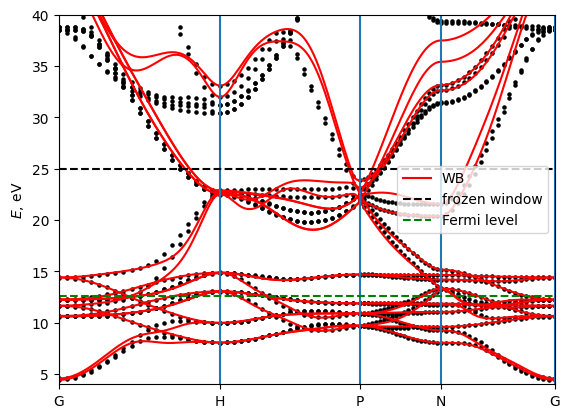

In [11]:

# plot the bands and compare with pw
# EF = 12

A = np.loadtxt("./pwscf/Fe_bands_pw.dat")
bohr_ang = scipy.constants.physical_constants['Bohr radius'][0] / 1e-10
alatt = 5.4235* bohr_ang
A[:,0]*= 2*np.pi/alatt
A[:,1] = A[:,1] 
plt.scatter(A[:,0], A[:,1], c="black", s=5)

    

bands_path.plot_path_fat(path,
                quantity=None,
                # save_file="Fe_bands.pdf",
                Eshift=0,
                Emin=-10, Emax=50,
                iband=None,
                mode="fatband",
                fatfactor=20,
                cut_k=False,
                linecolor="red",
                close_fig=False,
                show_fig=False,
                label=f"WB"
                )

plt.ylim(4, 40)
plt.hlines(froz_max, 0, A[-1,0], linestyles="dashed", label="frozen window", color="black")
plt.hlines(12.6, 0, A[-1,0], linestyles="dashed", label="Fermi level", color="green")
plt.legend()
plt.savefig("Fe_bands.pdf")


## 9. AHC and Ohmic conductivity

### 9.1 calculate 

In [12]:
results_grid = {}
efermi = np.linspace(12.4,12.8,1001)
param = dict(Efermi=efermi)
calculators_grid = {
     "CDOS": wb.calculators.static.CumDOS(**param),
                "ohmic": wb.calculators.static.Ohmic_FermiSea(**param),
                "ahc_internal": wb.calculators.static.AHC(kwargs_formula={"external_terms":False}, **param),
            "ahc_external": wb.calculators.static.AHC(kwargs_formula={"internal_terms":False}, **param ),	
}

grid =  wb.Grid(system, NKFFT=6, NK=48)

result_grid = wb.run(system, 
                     grid, 
                     calculators_grid, 
                    fout_name="Fe_grid",
                    adpt_num_iter=0,
                    symmetrize=False,  # we do not symmetrize here so that we can chaeck how symmetric are the WFs
                    use_irred_kpt=False,
                    print_progress_step=1,
                    print_Kpoints=False,
                    )


# plot the bands to compare with pw





Starting run()
Using the follwing calculators : 
############################################################

 'CDOS'  :  <wannierberri.calculators.static.CumDOS object at 0x72cde9bba6c0>  : Cumulative density of states
 'ohmic'  :  <wannierberri.calculators.static.Ohmic_FermiSea object at 0x72cfc823b8f0>  : Ohmic conductivity (:math:`S/m`)

        | With Fermi sea integral. Eq(31) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`\sigma_{\alpha\beta} = e^2/\hbar \tau \int [dk] \partial_\beta v_\alpha f`for \tau=1fs| Instruction: :math:`j_\alpha = \sigma_{\alpha\beta} E_\beta`
 'ahc_internal'  :  <wannierberri.calculators.static.AHC object at 0x72cfc823ad50>  : Anomalous Hall conductivity (:math:`s^3 \cdot A^2 / (kg \cdot m^3) = S/m`)

        | With Fermi sea integral Eq(11) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`O = -e^2/\hbar \int [dk] \Omega f`
        | Instruction: :math:`j_\alpha = \sigma_

### 5.2 Plot 

/tmp/ipykernel_99162/1474735278.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


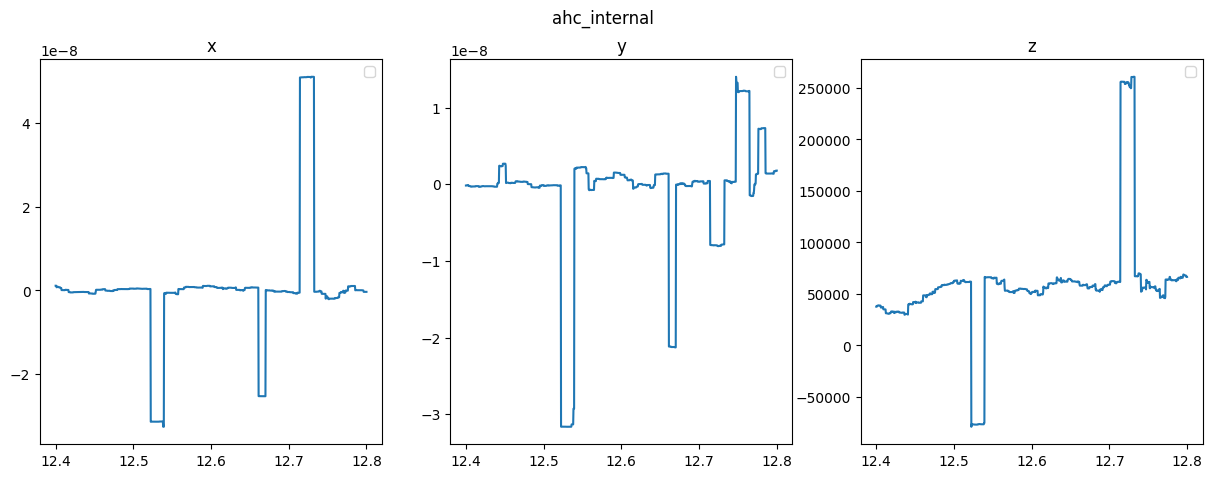

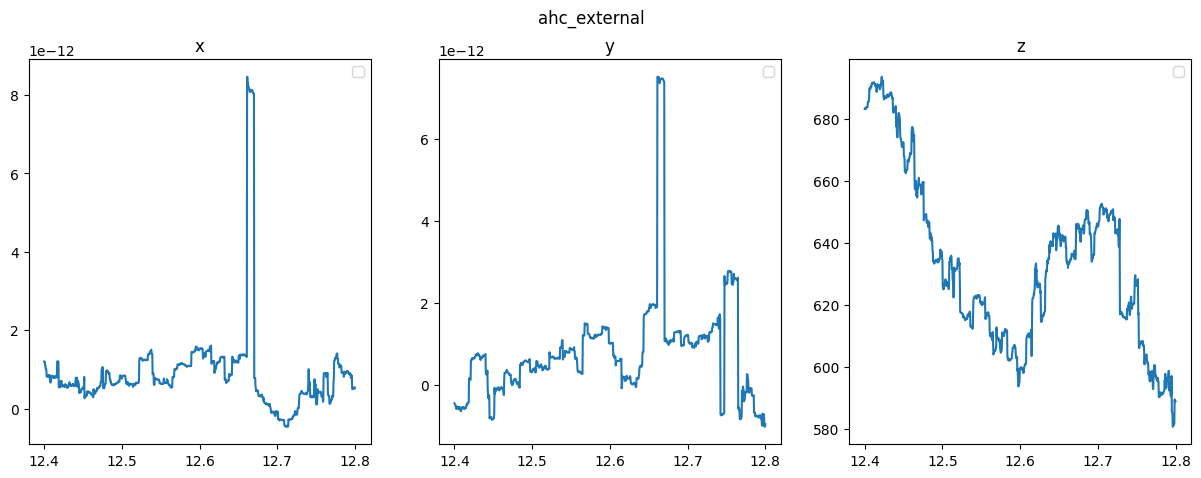

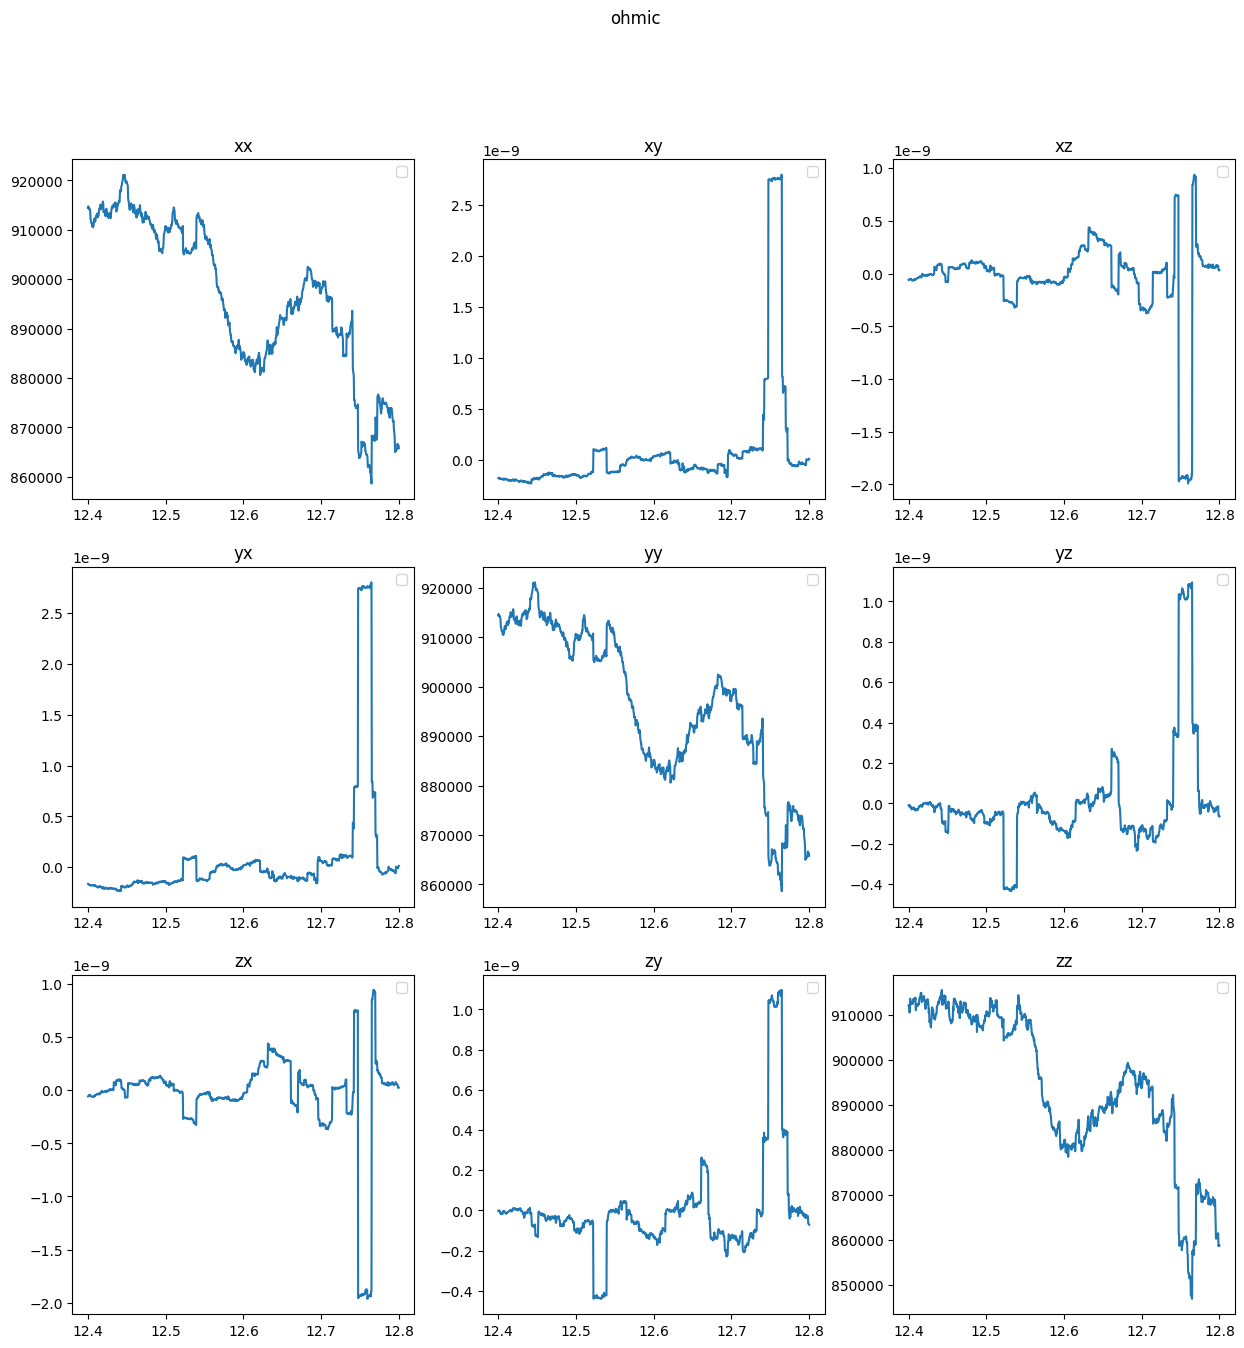

In [14]:
def plotxyz(axes, x, data, pre = "", label="",ls="-"):
    for i in range(3):
        ax =axes[i]
        ax.plot(x, data[:,i], ls, label=label)
        ax.set_title(f"{pre}{'xyz'[i]}")



quantities =  ["ahc_internal", "ahc_external","ohmic"]
    
nfig = len(quantities)
for quantity in quantities:
    fig = None
    res = result_grid.results[quantity]
    data = res.data
    E = res.Energies[0]
    if fig is None:
        if data.ndim == 2:
            nfigx = 1
            nfigy = data.shape[1]
        elif data.ndim == 3:
            nfigx = data.shape[1]
            nfigy = data.shape[2]
        fig, axes = plt.subplots(nfigx, nfigy, figsize=(5*nfigy,5*nfigx))
    if nfigx ==1:
        plotxyz(axes, E, data)
    else:
        for i in range(nfigx):
            plotxyz(axes[i], E, data[:,i], pre="xyz"[i], )
    for ax in axes.flat:
        ax.legend()
    fig.suptitle(quantity)
    plt.show()
    plt.close()
    
        
